In [1]:
%reload_ext nb_black
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import os

print(os.getcwd())

print(os.listdir(os.getcwd()))

C:\Users\jlim7\OneDrive\Documents\GitHub\For-Fun-LoL-Data
['.git', '.gitignore', '.ipynb_checkpoints', 'Data Analysis.ipynb', 'high_diamond_ranked_10min.csv', 'Lol Blue Wins Classification.ipynb', 'Lol Data.zip', 'README.md']


<IPython.core.display.Javascript object>

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [3]:
# the data set contains stats 10 min into diamond ranked games (~10k)
# data obtained from https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min
lol = pd.read_csv("high_diamond_ranked_10min.csv")
lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


<IPython.core.display.Javascript object>

# EDA

In [4]:
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

In [5]:
### Drop all red columns, focus solely on blue side.
blue_lol = lol[lol.columns.drop(list(lol.filter(regex="red")))]
blue_lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


<IPython.core.display.Javascript object>

In [6]:
# Eye balling the data, there are columns that are not necessary and can be dropped
blue_lol = blue_lol.drop(
    columns=[
        "gameId",
        "blueGoldPerMin",
        "blueGoldDiff",
        "blueCSPerMin",
        "blueAvgLevel",
        "blueExperienceDiff",
    ]
)

<IPython.core.display.Javascript object>

In [7]:
blue_lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,0,17210,17039,195,36
1,0,12,1,0,5,5,5,0,0,0,0,14712,16265,174,43
2,0,15,0,0,7,11,4,1,1,0,0,16113,16221,186,46
3,0,43,1,0,4,5,5,1,0,1,0,15157,17954,201,55
4,0,75,4,0,6,6,6,0,0,0,0,16400,18543,210,57


<IPython.core.display.Javascript object>

In [8]:
blue_lol.shape

(9879, 15)

<IPython.core.display.Javascript object>

In [9]:
# There does not appear to be any missing values in the data set.
blue_lol.isna().mean()

blueWins                        0.0
blueWardsPlaced                 0.0
blueWardsDestroyed              0.0
blueFirstBlood                  0.0
blueKills                       0.0
blueDeaths                      0.0
blueAssists                     0.0
blueEliteMonsters               0.0
blueDragons                     0.0
blueHeralds                     0.0
blueTowersDestroyed             0.0
blueTotalGold                   0.0
blueTotalExperience             0.0
blueTotalMinionsKilled          0.0
blueTotalJungleMinionsKilled    0.0
dtype: float64

<IPython.core.display.Javascript object>

In [10]:
blue_lol.dtypes

blueWins                        int64
blueWardsPlaced                 int64
blueWardsDestroyed              int64
blueFirstBlood                  int64
blueKills                       int64
blueDeaths                      int64
blueAssists                     int64
blueEliteMonsters               int64
blueDragons                     int64
blueHeralds                     int64
blueTowersDestroyed             int64
blueTotalGold                   int64
blueTotalExperience             int64
blueTotalMinionsKilled          int64
blueTotalJungleMinionsKilled    int64
dtype: object

<IPython.core.display.Javascript object>

In [11]:
# This will be the target variable (what we are trying to predict)
blue_lol["blueWins"].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

<IPython.core.display.Javascript object>

# Random Forest Classifier (1st Trial)

In [12]:
X = blue_lol.drop(columns=["blueWins"])
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)

<IPython.core.display.Javascript object>

In [13]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

In [14]:
model.score(X_train, y_train)

1.0

<IPython.core.display.Javascript object>

In [15]:
model.score(X_test, y_test)

0.7155870445344129

<IPython.core.display.Javascript object>

In [16]:
print_vif(X_train)

VIF results
-------------------------------
const                           782.199158
blueWardsPlaced                   1.010916
blueWardsDestroyed                1.024754
blueFirstBlood                    1.199873
blueKills                        13.515089
blueDeaths                        1.617713
blueAssists                       3.608523
blueEliteMonsters                      inf
blueDragons                            inf
blueHeralds                            inf
blueTowersDestroyed               1.598541
blueTotalGold                    18.224098
blueTotalExperience               4.167019
blueTotalMinionsKilled            3.035075
blueTotalJungleMinionsKilled      1.810184
dtype: float64
-------------------------------



C:\Users\jlim7\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


<IPython.core.display.Javascript object>

In [17]:
X = blue_lol.drop(
    columns=[
        "blueWins",
        "blueKills",
        "blueEliteMonsters",
        "blueDragons",
        "blueHeralds",
        "blueTotalGold",
    ]
)
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)

<IPython.core.display.Javascript object>

In [18]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

In [19]:
model.score(X_train, y_train)

1.0

<IPython.core.display.Javascript object>

In [20]:
model.score(X_test, y_test)

0.687753036437247

<IPython.core.display.Javascript object>

In [21]:
model.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state',
 'ccp_alpha')

<IPython.core.display.Javascript object>

In [22]:
grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 6],
    "n_estimators": [10, 100, 1000],
}
model = GridSearchCV(RandomForestClassifier(), grid, cv=2, n_jobs=-1,)

<IPython.core.display.Javascript object>

In [23]:
model.fit(X_train, y_train)
model.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 1000}

<IPython.core.display.Javascript object>

In [24]:
model.score(X_train, y_train)

0.7218777679362267

<IPython.core.display.Javascript object>

In [25]:
model.score(X_test, y_test)

0.7115384615384616

<IPython.core.display.Javascript object>

In [26]:
y_pred = model.predict(X_test)

<IPython.core.display.Javascript object>

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       990
           1       0.71      0.71      0.71       986

    accuracy                           0.71      1976
   macro avg       0.71      0.71      0.71      1976
weighted avg       0.71      0.71      0.71      1976



<IPython.core.display.Javascript object>

In [28]:
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win",],
    columns=["Predicted Lose", "Predicted Win",],
)

confusion_df.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,702,288
Actually Win,282,704


<IPython.core.display.Javascript object>

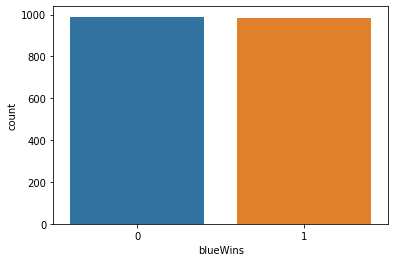

<IPython.core.display.Javascript object>

In [31]:
sns.countplot(y_test)
plt.show()

# SVC (1st Trial)

In [29]:
X = blue_lol.drop(
    columns=[
        "blueWins",
        "blueKills",
        "blueEliteMonsters",
        "blueDragons",
        "blueHeralds",
        "blueTotalGold",
    ]
)
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)

<IPython.core.display.Javascript object>

In [38]:
grid = {"C": [0.10, 1, 10, 100, 1000], "kernel": ["linear", "rbf"]}
model = GridSearchCV(SVC(), grid, cv=3, n_jobs=-1,)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
model.fit(X_train, y_train)
model.best_params_

{'C': 0.1, 'kernel': 'linear'}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
model.score(X_train, y_train)

0.7047956472225737

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
model.score(X_test, y_test)

0.7125506072874493

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
y_pred = model.predict(X_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       990
           1       0.71      0.71      0.71       986

    accuracy                           0.71      1976
   macro avg       0.71      0.71      0.71      1976
weighted avg       0.71      0.71      0.71      1976



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win",],
    columns=["Predicted Lose", "Predicted Win",],
)

confusion_df.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,705,285
Actually Win,283,703


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Logistic Regression (1st Trial)

In [47]:
X = blue_lol.drop(
    columns=[
        "blueWins",
        "blueKills",
        "blueEliteMonsters",
        "blueDragons",
        "blueHeralds",
        "blueTotalGold",
    ]
)
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
grid = {"penalty": ["l1", "l2", "elasticnet", "none"], "solver": ["lbfgs", "liblinear"]}
model = GridSearchCV(LogisticRegression(), grid, cv=3, n_jobs=-1,)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
model.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
model.score(X_train, y_train)

0.7066936606352018

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
model.score(X_test, y_test)

0.7125506072874493

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
y_pred = model.predict(X_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       990
           1       0.71      0.71      0.71       986

    accuracy                           0.71      1976
   macro avg       0.71      0.71      0.71      1976
weighted avg       0.71      0.71      0.71      1976



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win",],
    columns=["Predicted Lose", "Predicted Win",],
)

confusion_df.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,707,283
Actually Win,285,701


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>